In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330-2023s/blob/master/docs/calendar.html).**

## Imports 

In [2]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` under the data folder in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` under the data folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [3]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={autograde:2}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (40%) and `test_df` (60%) with `random_state = 123`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 40%/60% split because running cross-validation with this dataset can take a while on a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the model performance!_

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 2

In [4]:
train_df = None
test_df = None

train_df, test_df = train_test_split(census_df, test_size=0.6, random_state=123)

In [5]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [6]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values because they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [7]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape

(13024, 15)

In [8]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 `describe()` method
rubric={autograde:5}

**Your tasks:**

1. Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `census_summary`.
2. What is the highest hours per week someone reported? Store it in a variable called `max_hours_per_week`.
3. What is the most frequently occurring occupation in this dataset? Store it in a variable called `most_freq_occupation`.
4. Store the column names of the columns with missing values as a list in a variable called `missing_vals_cols`. 
5. Store the column names of all numeric-looking columns as a list in a variable called `numeric_cols`.  

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 5

In [9]:
census_summary = train_df.describe(include='all')
census_summary

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,13024.000000,12284,1.302400e+04,13024,13024.000000,13024,12281,13024,13024,13024,13024.000000,13024.000000,13024.000000,12783,13024
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,9123,NaN,4153,NaN,5936,1649,5195,11158,8700,NaN,NaN,NaN,11717,9875
mean,38.546913,NaN,1.884759e+05,NaN,10.057432,NaN,NaN,NaN,NaN,NaN,1079.831695,86.543074,40.395654,NaN,NaN
std,13.610225,NaN,1.040895e+05,NaN,2.553084,NaN,NaN,NaN,NaN,NaN,7322.034546,403.025863,12.285347,NaN,NaN
min,17.000000,NaN,1.376900e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.170962e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778990e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.365655e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [10]:
max_hours_per_week = census_summary.at['max', 'hours.per.week']
max_hours_per_week

99.0

In [11]:
most_freq_occupation = census_summary.at['top', 'occupation']
most_freq_occupation

'Prof-specialty'

In [12]:
#find columns with NaN
missing_vals_cols = []
for column in train_df.columns:
    if train_df[column].isnull().any():
        missing_vals_cols.append(column)

In [13]:
#observe data types
train_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

> It looks like all the numeric columns are integers, so no need to worry about looking for floats when isolating numeric cols.

In [14]:
#find integer columns
numeric_cols = []
for column in train_df.columns:
    if (train_df[column].dtype == 'int64'):
        numeric_cols.append(column)

In [15]:
# Sorting the lists for the autograder
missing_vals_cols.sort()
numeric_cols.sort()

In [16]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Visualizing features
rubric={points:5}

**Your tasks:**

1. Visualize the histograms of numeric features.  
2. From the visualizations, which features seem relevant for the given prediction task?

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 5

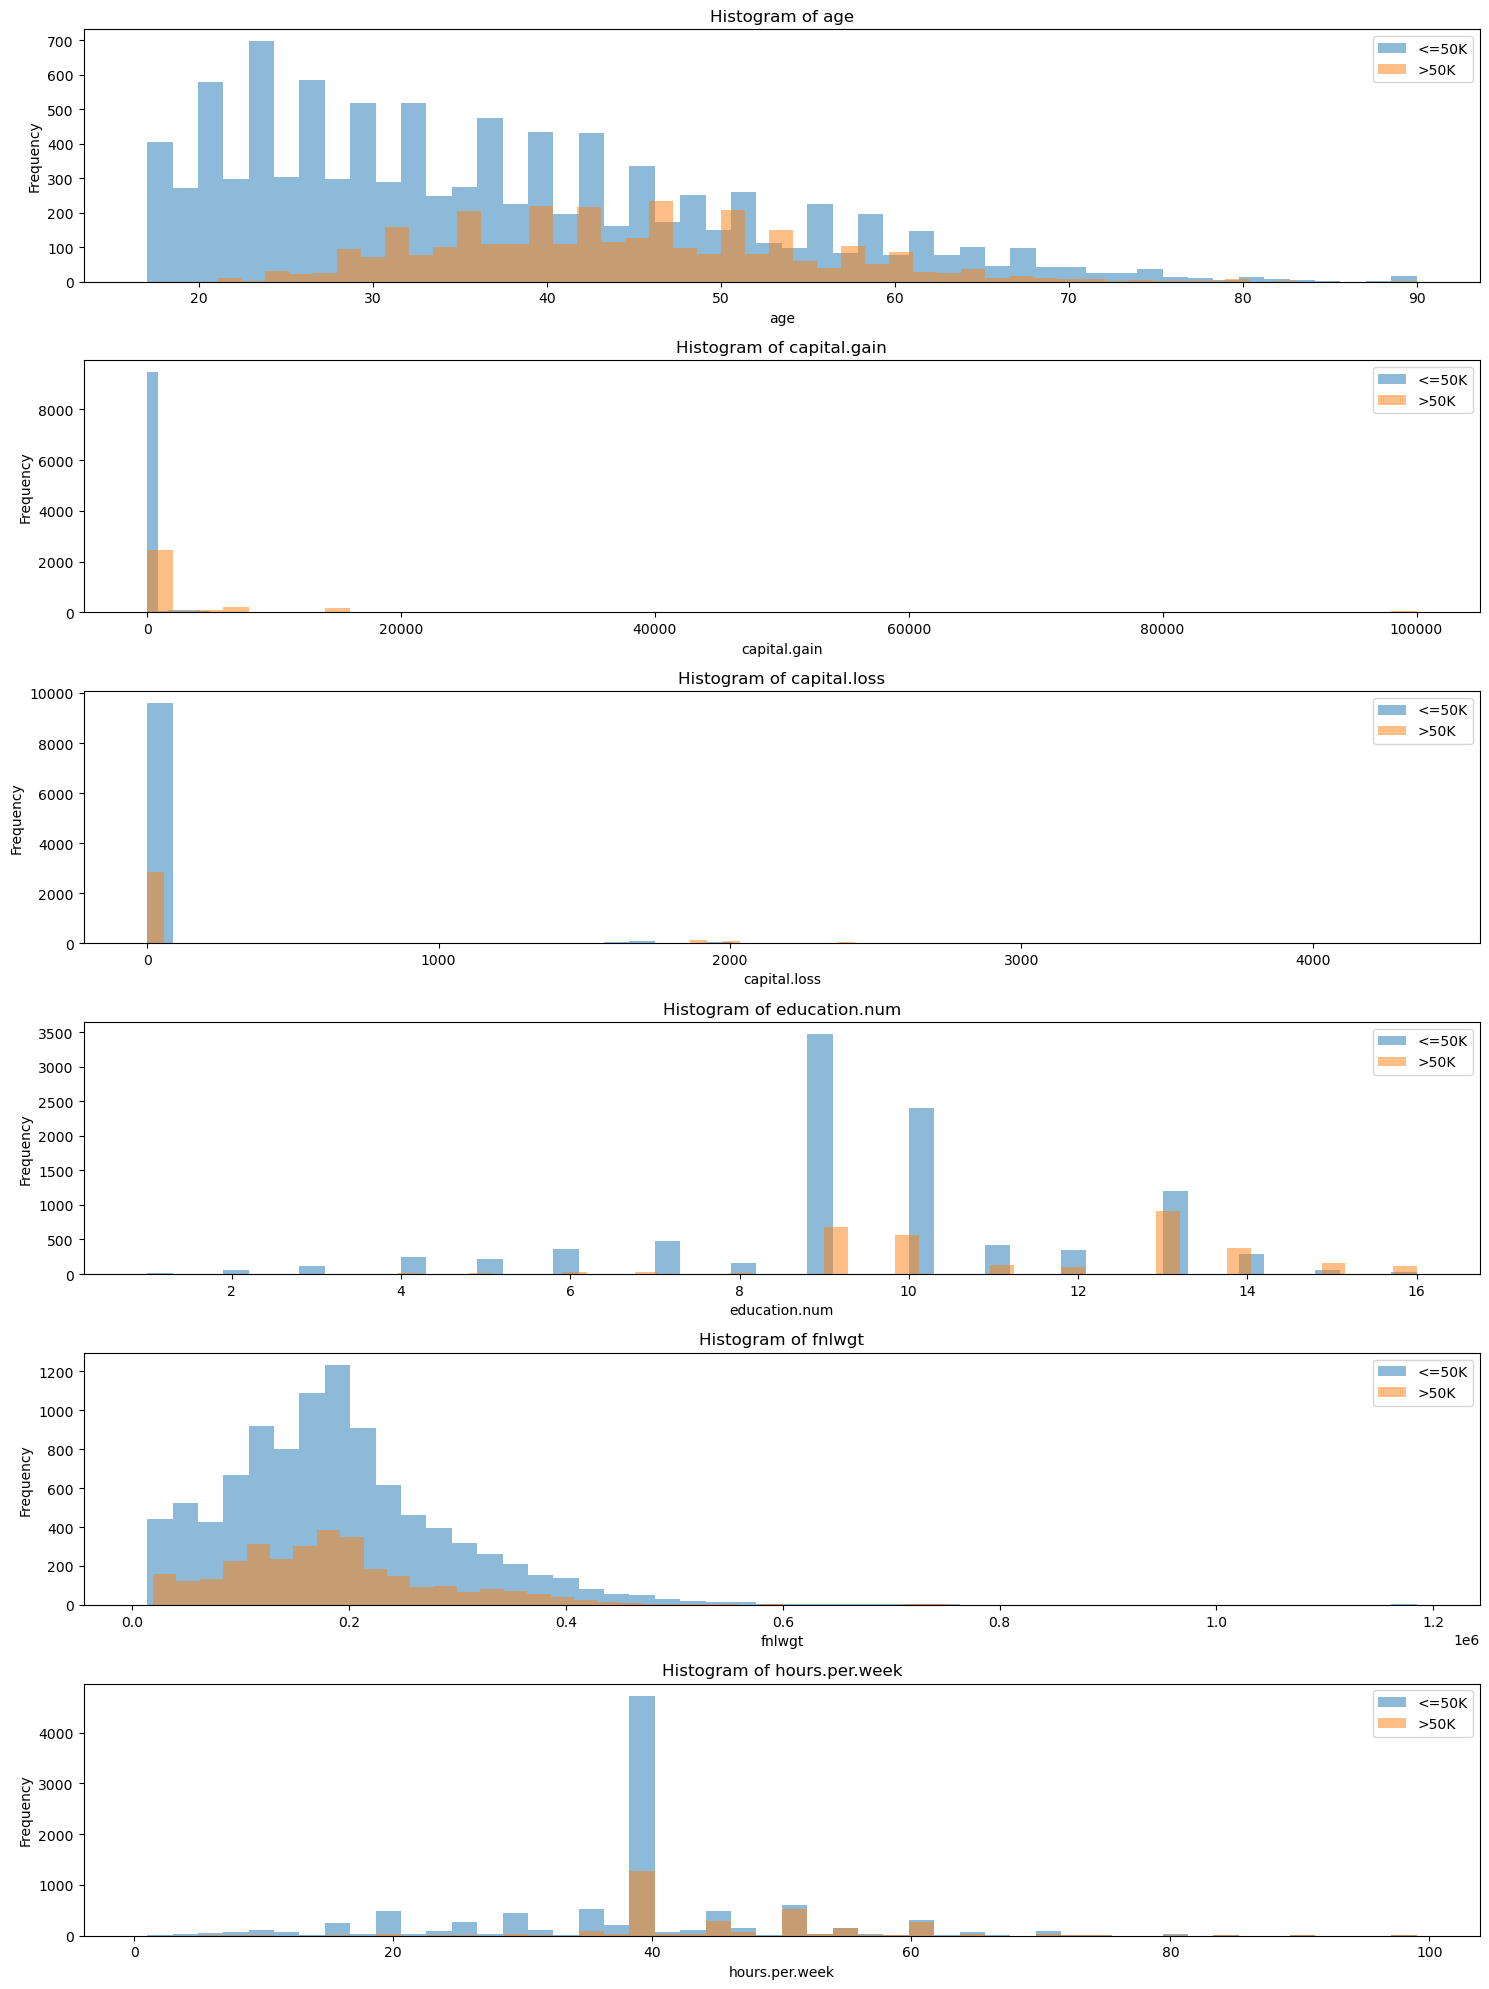

In [17]:
def plot_features(features):
    fig, ax = plt.subplots(len(features), figsize=(15, 20))
    for i, feature in enumerate(features):
        train_df.groupby("income")[feature].plot.hist(ax=ax[i], bins=50, alpha=0.5, legend=True)
        ax[i].set_xlabel(feature)
        ax[i].set_ylabel('Frequency')
        ax[i].set_title("Histogram of " + feature)
    fig.tight_layout()
    plt.show()

plot_features(numeric_cols)

>Based on the histogram, the age looks relevant. There looks to be a difference in the distribution of incomes between older and younger people, with older people earning more on average. 

>Capital gains and losses are both 0 for the vast majority of people, however it looks like of the people who do not have 0 for this feature, most at earning >50k. As such, it may be relevant. 

>The education num also looks to be relevant, considering the majority of people with lower education num values tend to be in the <=50k group. 

>Fnlwgt seems to have significant overlap between the two groups. As such, it may not be relevant, unless it has interactions with other features in the dataset. 

>Hours per week also looks to be relevant, with lower income people tending to work less, and higher income people working more on average. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Identify transformations to apply
rubric={points:13}

Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `census_df`.  

**Your tasks:**
1. Write your justification or explanation for each row in the explanation column. An example explanation is given for the age column. 

> Note: This question is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation. That said, in this assignment, go with the transformations provided below. 

<div class="alert alert-warning">

Solution_2.3
    
</div>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| workclass | imputation, one-hot encoding | Has missing values, hence the need for imputation. Also since values are categorical and non-ordinal, need one-hot encoding|
| fnlwgt | drop | Significant overlap between target groups, as seen in the histogram above. As such it may not be useful for distinguishing between income groups, and it makes sense to drop this feature.|
| education | ordinal encoding | Categorical without missing values, but ordered, hence we want ordinal encoding. |
| education.num | drop | If we're already including the education col, we don't want to duplicate it by adding this one as well. |
| marital.status | one-hot encoding  | Categorical without missing values, but non-ordinal so one-hot is needed.|
| occupation | imputation, one-hot encoding  | Missing values, hence the need for imputation. One-hot encoding since the feature is categorical but not ordered. |
| relationship | one-hot encoding  | A categorical feature without missing values or an order, hence one-hot encoding makes sense. |
| race | drop  | Including this feature adds ethical considerations, which are beyond the scope of this model's purpose. |
| sex | one-hot encoding with "binary=True" | Categorical feature with no missing values and only two categories, so you can represent it with one column using True/False. |
| capital.gain | scaling |  Numeric feature with no missing values. Always good to scale, especially since the range for this feature is very large (0-99999) compared to other features. | 
| capital.loss | scaling |  Numeric feature with no missing values. Always good to scale, especially since the range for this feature is very large (0-4356) compared to other features.|
| hours.per.week | scaling | Numeric feature with no missing values. Always good to scale, especially since the range for this feature (1-99) is smaller than the cap gain/losses |
| native.country | imputation, one-hot encoding | Missing values so need imputation. Categorical without an inherent order, hence one-hot encoding. | 


_Points:_ 13

<!-- END QUESTION -->

<br><br>

### 2.4 Identify feature types 
rubric={autograde:5}


**Your tasks:**
1. Based on the types of transformations you want to apply on the features, identify different feature types and store them in the variables below as lists.  

<div class="alert alert-warning">
    
Solution_2.4
    
</div>

_Points:_ 5

In [18]:
# Fill in the lists below.
numeric_features = ['age', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 'relationship', 'native.country']
ordinal_features = ['education']
binary_features = ['sex']
drop_features = ['fnlwgt', 'education.num', 'race']
target = "income"

...

Ellipsis

In [19]:
# Sorting all the lists above for the autograder
numeric_features.sort()
categorical_features.sort()
ordinal_features.sort()
binary_features.sort()
drop_features.sort()

In [20]:
grader.check("q2.4")

q2.4 results: All test cases passed!

<br><br><br><br>

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  
rubric={autograde:2}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

<div class="alert alert-warning">
    
Solution_3.1
    
</div>

_Points:_ 2

In [21]:
X_train = train_df.drop(columns=['income'])
y_train = train_df['income']
X_test = test_df.drop(columns=['income'])
y_test = test_df['income']

In [22]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5917,26,Private,214303,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,<=50K
32065,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
28237,27,Private,202206,11th,7,Separated,Farming-fishing,Other-relative,White,Male,0,0,40,Puerto-Rico,<=50K
12846,49,Private,151584,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
25706,19,Private,351802,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,35,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,48,Private,70668,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,50,United-States,<=50K
17730,35,Private,340018,10th,6,Never-married,Other-service,Unmarried,Black,Female,0,0,38,United-States,<=50K
28030,26,Private,373553,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,42,United-States,<=50K
15725,28,Private,155621,5th-6th,3,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Columbia,<=50K


In [23]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<br><br>

### 3.2 Dummy classifier
rubric={autograde:2}

**Your tasks:**

1. Carry out 5-fold cross-validation using `scikit-learn`'s `cross_validate` function with `return_train_scores=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

<div class="alert alert-warning">
    
Solution_3.2
    
</div>

_Points:_ 2

In [24]:
dummy_df = pd.DataFrame(cross_validate(DummyClassifier(), X_train, y_train, cv=5, return_train_score=True))
dummy_df

,fit_time,score_time,test_score,train_score
0,0.015907,0.009170,0.758157,0.758230
1,0.007134,0.004309,0.758157,0.758230
2,0.006870,0.004459,0.758157,0.758230
3,0.005595,0.004426,0.758157,0.758230
4,0.006079,0.004495,0.758449,0.758157


In [25]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Discussion
rubric={points:2}

**Your tasks:**

1. Hopefully, you were able to run cross-validation with dummy classifier successfully in the question above. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? 

<div class="alert alert-warning">
    
Solution_3.3
    
</div>

_Points:_ 2

No, you couldn't. The data contains categorical variables which can't be used in the SVC model without being preprocessed. You could train it only using numeric variables, but it would still probably perform poorly without preprocesssing (scaling, in particular).

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Preprocessing
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. In this exercise, first, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer`. For example, the code below creates a `numeric_transformer` for numeric features. 

In [26]:
numeric_transformer = StandardScaler()

In the exercises below, you'll create transformers for other types of features. 

<br><br>

### 4.1 Preprocessing ordinal features
rubric={autograde:5}

**Your tasks:**

1. Create a transformer called `ordinal_transformer` for our ordinal features. 

<div class="alert alert-warning">
    
Solution_4.1
    
</div>

_Points:_ 5

In [27]:
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school',
                    'Assoc-voc', 'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)
assert (set(education_levels) == set(X_train['education'].unique()))

In [28]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<br><br>

### 4.2 Preprocessing binary features
rubric={autograde:2}

**Your tasks:**

1. Create a transformer called `binary_transformer` for our binary features.

> _Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

<div class="alert alert-warning">
    
Solution_4.2
    
</div>

_Points:_ 2

In [29]:
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)

In [30]:
grader.check("q4.2")

q4.2 results: All test cases passed!

<br><br>

### 4.3 Preprocessing categorical features
rubric={autograde:4}

In Exercise 2.3, we saw that there are 3 categorical features with missing values. So first we need to impute the missing values and then encode these features with one-hot encoding. For the purpose of this assignment, let's just have imputation as the first step for all categorical features even when they do not have missing values. This should be OK because if a feature doesn't have any missing value,  imputation won't be applied. 

If we want to apply more than one transformation on a set of features, we need to create a [`scikit-learn` `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). For example, for categorical features we can create a `scikit-learn` `Pipeline` with first step as imputation and the second step as one-hot encoding. 

**Your tasks:**

1. Create a `sklearn` `Pipeline` using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) called `categorical_transformer` for our categorical features with two steps: `SimpleImputer` for imputation with `strategy="constant"` and `fill_value="missing"` and `OneHotEncoder` with `handle_unknown="ignore"` and `sparse=False` for one-hot encoding. 

<div class="alert alert-warning">
    
Solution_4.3
    
</div>

_Points:_ 4

In [31]:
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='missing'), 
                                        OneHotEncoder(handle_unknown='ignore', sparse=False))


In [32]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<br><br>

### 4.4 Creating a column transformer. 
rubric={autograde:7}

**Your tasks:**
1. Create a `sklearn` `ColumnTransformer` named `preprocessor` using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) with the transformers defined in the previous exercises. Use the sequence below in the column transformer and add a "drop" step for the `drop_features` in the end.  
    - `numeric_transformer`
    - `ordinal_transformer`
    - `binary_transformer`
    - `categorical_transformer`
2. Transform the data by calling `fit_transform` on the training set and save it as a dataframe in a variable called `transformed_df`. How many new columns have been created in the preprocessed data in comparison to the original `X_train`? Store the difference between the number of columns in `transformed_df` and `X_train` in a variable called `n_new_cols`. 

<div class="alert alert-warning">
    
Solution_4.4
    
</div>

_Points:_ 7

In [33]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features), 
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features))

In [34]:
transformed_df = preprocessor.fit_transform(X_train)
n_new_cols = transformed_df.shape[1] - X_train.shape[1]

In [35]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<br><br><br><br>

## Exercise 5: Building models 

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Use it to keep track of your results. 

In [36]:
results_dict = {}  # dictionary to store all the results

In [37]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Below I'm showing an example where I call `mean_std_cross_val_scores` with `DummyClassifier`. The function calls `cross_validate` with the passed arguments and returns a series with mean cross-validation results and std of cross-validation. When you train new models, you can just add the results of these models in `results_dict`, which can be easily converted to a dataframe so that you can have a table with all your results. 

In [38]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 123)
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.050 (+/- 0.005),0.023 (+/- 0.005),0.758 (+/- 0.000),0.758 (+/- 0.000)


<br><br>

<!-- BEGIN QUESTION -->

### 5.1 Trying different classifiers
rubric={points:10}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 4.4 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline and get the mean cross-validation scores with std by calling the `mean_std_cross_val_scores` function above. 
    - Store the results in a dataframe called `income_pred_results_df` with the model names in the `models` dictionary below as the index and each row representing results returned by `mean_std_cross_val_scores` function above. In other words, `income_pred_results_df` should look similar to the `results_df` dataframe above with more rows for the models below. 
    
> This might take a while to run. Be patient! 

In [39]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

for key in models.keys():
    pipe = make_pipeline(preprocessor, models[key])
    results_dict.update({key : mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)})

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

_Points:_ 10

In [40]:
income_pred_results_df = pd.DataFrame(results_dict).T

In [41]:
income_pred_results_df

,fit_time,score_time,test_score,train_score
dummy,0.050 (+/- 0.005),0.023 (+/- 0.005),0.758 (+/- 0.000),0.758 (+/- 0.000)
decision tree,0.126 (+/- 0.014),0.023 (+/- 0.003),0.814 (+/- 0.012),0.987 (+/- 0.001)
kNN,0.044 (+/- 0.003),0.231 (+/- 0.054),0.836 (+/- 0.008),0.884 (+/- 0.003)
RBF SVM,4.263 (+/- 0.133),2.595 (+/- 0.082),0.852 (+/- 0.005),0.855 (+/- 0.002)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Discussion 
rubric={points:5}

**Your tasks:**

1. Examine the train and validation accuracies and `fit` and `score` times for all the models in the results above. How do the validation accuracies compare to the `DummyClassifier` model? Which model has the best validation accuracy? Which model is the fastest one? Which model is overfitting the most and the least?  


<div class="alert alert-warning">
    
Solution_5.2
    
</div>

_Points:_ 5

**a) How do the validation accuracies compare to the DummyClassifier model?**
- The DummyClassifier had an accuracy of 0.758, which was lower than the decision tree, kNN, and SVC (0.814, 0.836, 0.852 respectively). This indicates all 3 of these models have some value in their predictions. 

**b) Which model has the best validation accuracy?**
- The SVC model had the best validation accuracy, at 0.852. 

**c) Which model is the fastest one?**
- the kNN was the fastest to fit (0.044), while the decision tree and dummy were tied for fastest to score (0.023). 

**d) Which model is overfitting the most and the least?**
- The decision tree model is overfitting the most, with nearly a 100% (0.987) training score and a noticeably lower (0.817) cv score. This is unsurprising, as we haven't optimized the maxdepth hyperparameter, so the tree defaults to expanding fully. 
- Naturally, the dummy model is overfitting the least (since it's doing a very poor job of fitting the data to begin with). Of the 3 new models, the SVC is overfitting the least, with nearly identical traning (0.855) and testing (0.852) accuracies. It does, however, have fit and score times notably longer than any of the others. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice, you'll carry out hyperparameter optimization for all different hyperparameters of the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter, namely `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` below: 
    - Create a pipeline object with two steps: preprocessor from 4.4 and `SVC` classifier with the `C` value.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Store it in a variable called `best_C`. (Since this question is not autograded, please store the value directly as a number, something like `best_C = 0.001`, if `C = 0.001` is giving you the best CV score.) Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this will take a while. Please be patient. 

In [42]:
param_grid = {"C": np.logspace(-1, 2, 4)}
param_grid

{'C': array([  0.1,   1. ,  10. , 100. ])}

<div class="alert alert-warning">
    
Solution_5.3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [43]:
results_dict = {}
for c in param_grid['C']:
    pipe = make_pipeline(preprocessor, SVC(C=c, random_state=123))
    results_dict.update({c : mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True)})

In [44]:
hyper_param_opt_df = pd.DataFrame(results_dict).T
hyper_param_opt_df

,fit_time,score_time,test_score,train_score
0.1,5.377 (+/- 0.384),3.171 (+/- 0.077),0.838 (+/- 0.006),0.838 (+/- 0.002)
1.0,4.541 (+/- 0.314),2.671 (+/- 0.223),0.852 (+/- 0.005),0.855 (+/- 0.002)
10.0,4.315 (+/- 0.223),2.552 (+/- 0.162),0.858 (+/- 0.005),0.862 (+/- 0.002)
100.0,5.709 (+/- 0.174),2.477 (+/- 0.099),0.860 (+/- 0.006),0.871 (+/- 0.002)


In [45]:
best_C = 100.0

The highest cv score is using C=100 (0.860). It's also not overfitting by much, since the training score is similar (0.873). Thus C=100 seems to be the best cv-score. 

This is different from the default C value, which is 1.0. 

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 6: Evaluating on the test set 
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise, you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 6.1 Scoring on the unseen test set 
rubric={autograde:4}

**Your tasks:**

1. Create a pipeline named `final_pipeline` with the preprocessor from 4.4 as the first step and the best performing SVC model from 5.4 as the second step. 
2. Train the pipeline on the entire training set `X_train` and `y_train`. 
3. Score the pipeline on `X_test` and `y_test` and store the score in a variable called `test_score`.  

<div class="alert alert-warning">
    
Solution_6.1
    
</div>

_Points:_ 4

In [46]:
final_pipeline = make_pipeline(preprocessor, SVC(C=100, random_state=123))
final_pipeline.fit(X_train, y_train)
test_score = final_pipeline.score(X_test, y_test)
test_score

0.8497722270563546

In [47]:
grader.check("q6.1")

q6.1 results: All test cases passed!

<br><br><br><br>

## Exercise 7: Short answer questions

<!-- BEGIN QUESTION -->

### 7.1 kNNs toy example
rubric={points:3}

Suppose you want to get predictions using the $k$-nearest neighbour algorithm on the toy dataset below. 

$$ X = \begin{bmatrix}5 & 2\\4 & -2\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

Suppose you are given a new data point $x=\begin{bmatrix} 0\\0\end{bmatrix}$.  

1. What would the model predict when $k=1$?
2. What would the model predict when $k=3$?
3. What would the model predict when $k=3$ if we were doing regression rather than classification? 

_Points:_ 3

1. When k=1, the model would predict 1, since the nearest neighbor is the datapoint at [2,2], and it has a value of 1. 
2. When k=3, the model would predict 0, since the three nearest neighbors are the datapoints at [2,2], [4,-2], and [5,2], which have values of 1, 0, and 0 respectively. Since 2/3 have a value of 0, the kNN model would predict 0. 
3. The model would predict 1/3, since regression would take the average of the 3 nearest neighbors, which as stated above are 0, 0, and 1. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 7.2 Preprocessing
rubric={points:8}

1. What is the problem with calling `fit_transform` on your test data with `StandardScaler`?
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. What are two advantages of using sklearn Pipelines? 
4. When is it appropriate to use sklearn `ColumnTransformer`? 

_Points:_ 8

1. Scaling the test data presents a few problems. If you're fitting the scaler to your test data, it violates the golden rule and biases the model. Also, scaling the test data removes any interpretability from the results. 
2. It's important to follow the golden rule so that you don't bias your model. The point of the testing split is to see how the model performs on new data it's never seen before. If you've exposed the model in any way to the testing data during development, you will overestimate it's accuracy when testing it and no longer reflect the general accuracy of the model. By violating the golden rule, it will ***seem*** like you've created a better classifier when in fact you haven't. 
3. i) sklearn Pipelines allow you to perform cross-validation in a simple and accurate way without leaking the 'test' (cv) data during optimization. 

   ii) sklearn Pipelines allow you to apply multiple transformations inside a column transformer, in order to fully process a column that needs multiple steps.
4. When you have features which require different preprocessing (ie. a categorical feature that needs one-hot encoding and a numerical feature that requires scaling). 

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](img/eva-well-done.png)

